In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import HTML,display
import PIL
from PIL import Image
import os
import glob
from tqdm import tqdm
import cv2


import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
class RVDataset():
    def __init__(self, images_list, masks_list, transform=None):
        self.images = images_list
        self.masks = masks_list
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        mask_path = self.masks[idx]

        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")

        if self.transform is not None:
            # Apply the transformations to the PIL images
            image = self.transform(image)
            mask = self.transform(mask)

        # Convert PIL Image to numpy array
        image_np = np.array(image)
        mask_np = np.array(mask)

        # Binarize the mask. Assuming your mask has 0-255 range, hence using 127.5 as threshold.
        mask_np = (mask_np > 127.5).astype(np.float32)

        # Add channel dimension (making it 1 x height x width)
        image_np = np.expand_dims(image_np, axis=0)
        mask_np = np.expand_dims(mask_np, axis=0)

        # Convert numpy arrays to PyTorch tensors
        image_tensor = torch.from_numpy(image_np).float()
        mask_tensor = torch.from_numpy(mask_np).float()

        return image_tensor, mask_tensor, image_path, mask_path

transform = transforms.Compose([
    transforms.Resize((304, 304)),
])

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
modified_image_dir  = "/content/drive/MyDrive/EchoPE/Train/Frames_300/"
modified_mask_dir  = "/content/drive/MyDrive/EchoPE/Train/Masks_300/"

# Lists of modified image and mask paths
modified_image_data_path_list = sorted([os.path.join(modified_image_dir, f) for f in os.listdir(modified_image_dir) if f.endswith('.png')])
modified_mask_data_path_list = sorted([os.path.join(modified_mask_dir, f) for f in os.listdir(modified_mask_dir) if f.endswith('.png')])

dataset = RVDataset(images_list = modified_image_data_path_list, masks_list= modified_mask_data_path_list, transform = transform)

In [5]:
def visualize_tensor(tensor, title=""):
    plt.imshow(tensor.cpu().detach().numpy(), cmap='gray')
    plt.title(title)
    plt.show()

class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c + out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)

        # Crop the skip tensor to match upsampled tensor's size
        _, _, h, w = x.shape
        skip = skip[:, :, :h, :w]

        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))
    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.e1 = encoder_block(1, 64)   # Assuming grayscale input
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        # Bridge
        self.b = conv_block(512, 1024)

        # Decoder
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        # Final Output
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        b = self.b(p4)

        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)
        return outputs

torch.Size([1, 304, 304])
torch.Size([1, 304, 304])


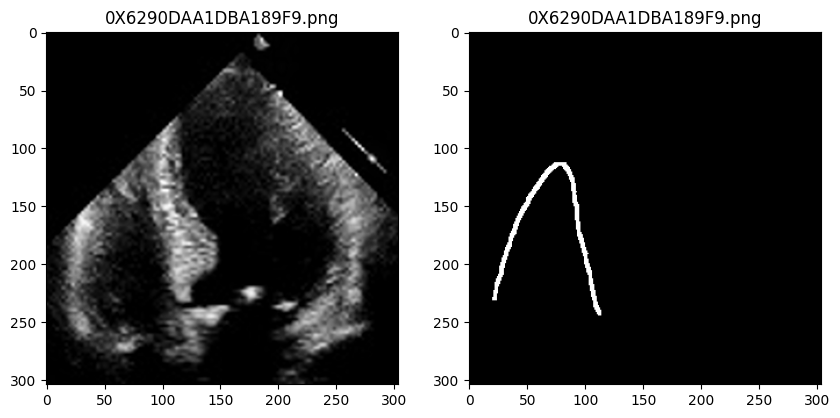

In [6]:
image, mask, image_path, mask_path = dataset[10]
print(mask.shape)
print(image.shape)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image.squeeze(), cmap = "gray")
ax[0].set_title(os.path.basename(image_path))
ax[1].imshow(mask.squeeze(), cmap = "gray")
ax[1].set_title(os.path.basename(mask_path))
plt.show()

In [8]:
from torch.utils.data import DataLoader, random_split

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create an instance of the UNet model
model = UNet()
model = model.to(device)  # Move model to GPU if available

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
# Binary cross entropy with logits is commonly used for binary segmentation tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create data loaders for training (and optionally validation)
train_dataset = RVDataset(images_list= modified_image_data_path_list, masks_list= modified_mask_data_path_list, transform = transform)


val_size = int(len(train_dataset) * 0.2)  # e.g., 20% for validation
train_size = len(train_dataset) - val_size

# Split the dataset
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create the DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8 , shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [9]:
def dice_coefficient(predicted, target):
    # Flatten the tensors
    predicted = predicted.view(-1)
    target = target.view(-1)

    intersection = (predicted * target).sum()
    return (2. * intersection) / (predicted.sum() + target.sum())

In [11]:
num_epochs = 200
for epoch in range(num_epochs):
    # Training Phase
    model.train()  # Set the model to training mode
    epoch_loss = 0
    epoch_dice = 0

    for batch in train_loader:
        images, masks, image_path, mask_path = batch
        images, masks = images.to(device), masks.to(device)  # Move data to GPU if available

        # Forward pass
        outputs = model(images)
        outputs = F.interpolate(outputs, size=(304, 304), mode='bilinear', align_corners=True)

        # Compute the loss
        loss = criterion(outputs, masks)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Calculate Dice Coefficient
        with torch.no_grad():
            predicted = torch.sigmoid(outputs)  # Apply sigmoid to get values between 0 and 1
            predicted = (predicted > 0.5).float()  # Binarize the output
            intersection = (predicted * masks).sum()
            dice_val = (2. * intersection) / (predicted.sum() + masks.sum())
            epoch_dice += dice_val.item()

    # Validation Phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    val_dice = 0

    with torch.no_grad():
        for batch in val_loader:
            images, masks, image_path, mask_path = batch
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)
            outputs = F.interpolate(outputs, size=(304, 304), mode='bilinear', align_corners=True)

            # Compute the loss
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            # Calculate Dice Coefficient for validation set
            predicted = torch.sigmoid(outputs)  # Apply sigmoid to get values between 0 and 1
            predicted = (predicted > 0.5).float()  # Binarize the output
            intersection = (predicted * masks).sum()
            dice_val = (2. * intersection) / (predicted.sum() + masks.sum())
            val_dice += dice_val.item()

    # Print training and validation results
    train_loss_avg = epoch_loss / len(train_loader)
    train_dice_avg = epoch_dice / len(train_loader)
    val_loss_avg = val_loss / len(val_loader)
    val_dice_avg = val_dice / len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Training Loss: {train_loss_avg:.4f}, "
          f"Training Dice: {train_dice_avg:.4f}, "
          f"Validation Loss: {val_loss_avg:.4f}, "
          f"Validation Dice: {val_dice_avg:.4f}")

Epoch 1/200, Training Loss: 0.4736, Training Dice: 0.0139, Validation Loss: 1.0518, Validation Dice: 0.0180
Epoch 2/200, Training Loss: 0.2865, Training Dice: 0.0000, Validation Loss: 0.3390, Validation Dice: 0.0000
Epoch 3/200, Training Loss: 0.2234, Training Dice: 0.0000, Validation Loss: 0.2329, Validation Dice: 0.0000
Epoch 4/200, Training Loss: 0.1811, Training Dice: 0.0000, Validation Loss: 0.1670, Validation Dice: 0.0000
Epoch 5/200, Training Loss: 0.1499, Training Dice: 0.0000, Validation Loss: 0.1420, Validation Dice: 0.0000
Epoch 6/200, Training Loss: 0.1252, Training Dice: 0.0000, Validation Loss: 0.1211, Validation Dice: 0.0000
Epoch 7/200, Training Loss: 0.1075, Training Dice: 0.0000, Validation Loss: 0.0983, Validation Dice: 0.0000
Epoch 8/200, Training Loss: 0.0946, Training Dice: 0.0000, Validation Loss: 0.0843, Validation Dice: 0.0000
Epoch 9/200, Training Loss: 0.0844, Training Dice: 0.0000, Validation Loss: 0.0871, Validation Dice: 0.0000
Epoch 10/200, Training Loss:

KeyboardInterrupt: ignored

In [ ]:
from skimage.transform import resize

def overlay_grayscale_mask_on_image(image, mask, color=(255, 0, 0)):
    """
    Overlay the grayscale mask on the grayscale image.
    :param image: The original grayscale image.
    :param mask: The grayscale mask.
    :param color: RGB color for mask overlay. Default is red.
    :return: The image with mask overlaid.
    """

    mask_np = np.array(mask).squeeze()

    # Resize the mask to match the image dimensions
    mask_np = resize(mask_np, (45, 150))
    image_np = np.array(image).squeeze()
    # Normalize the image values to [0, 1] range
    image_np = (image_np - np.min(image_np)) / (np.max(image_np) - np.min(image_np))
    # Convert grayscale image to RGB
    image_rgb = np.stack([image_np]*3, axis=-1) * 255.0  # Scale to [0, 255]
    print("Max mask value:", mask_np.max())
    print("Min mask value:", mask_np.min())

    # Overlay the mask on each channel of the image
    for i in range(3):
        image_rgb[:,:,i] = np.where(mask_np > 0.1, color[i], image_rgb[:,:,i])

    return image_rgb

# Let's visualize an example
#overlay = overlay_grayscale_mask_on_image(image, mask)
#plt.imshow(overlay.astype(np.uint8))
#plt.axis('off')
#plt.show()

In [ ]:
def extract_coordinates_from_mask(mask, threshold= 0.95):
    """Extract x, y coordinates from the binary mask."""
    coords = np.column_stack(np.where(mask > threshold))
    return coords

def compute_mean_point(coordinates):
    """Compute the mean x, y values from a list of coordinates."""
    mean_x = int(np.mean([x[1] for x in coordinates]))
    mean_y = int(np.mean([x[0] for x in coordinates]))
    return mean_x, mean_y

def preprocess_image(image_path):
    # Load the image
    image = Image.open(image_path).convert("L")
    image = image.resize((150, 45), Image.ANTIALIAS)
    # Convert PIL Image to numpy array
    image = np.array(image)
    # Add channel dimension (making it 1 x height x width)
    image = np.expand_dims(image, axis=0)
    # Convert numpy arrays to PyTorch tensors
    image_tensor = torch.from_numpy(image).float()
    image_tensor = image_tensor.unsqueeze(1)
    print(image_tensor.shape)
    return image_tensor

def postprocess_output(output_tensor):
    # Move to CPU and convert to numpy
    return output_tensor.detach().cpu().numpy().squeeze()

# Move model to CUDA if available
if torch.cuda.is_available():
    model = model.cuda()

# Process a new image
image_path = "/content/drive/MyDrive/AI NYU Langone/Patient3/Frames/img14.tif"
image_tensor = preprocess_image(image_path)

# Move image_tensor to CUDA if available
if torch.cuda.is_available():
    image_tensor = image_tensor.cuda()

# Pass the image through the U-Net
with torch.no_grad():
    mask = model(image_tensor)

# Convert the mask to numpy for visualization
mask_np = postprocess_output(mask)

# Extract coordinates from the mask
coordinates = extract_coordinates_from_mask(mask_np)

# Compute the mean point
mean_x, mean_y = compute_mean_point(coordinates)
print(f"Mean point is at (x={mean_x}, y={mean_y})")

# Overlay the mask on the original image
overlay = overlay_grayscale_mask_on_image(image_tensor.cpu().squeeze(), mask_np)

plt.imshow(overlay.astype(np.uint8))
plt.annotate(f"({mean_x}, {mean_y})", (mean_x, mean_y), color='red', fontsize=10,
             xytext=(-25,-10), textcoords='offset points')  # Label the mean point
plt.axis('on')
plt.show()

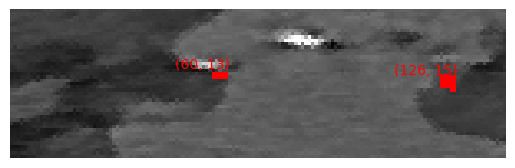

In [ ]:
from skimage.transform import resize
from scipy.ndimage import label

# Your provided functions remain largely the same
def overlay_grayscale_mask_on_image(image, mask, color=(255, 0, 0)):
    """..."""
    mask_np = np.array(mask).squeeze()
    mask_np = resize(mask_np, (45, 150))
    image_np = np.array(image).squeeze()
    image_np = (image_np - np.min(image_np)) / (np.max(image_np) - np.min(image_np))
    image_rgb = np.stack([image_np]*3, axis=-1) * 255.0

    for i in range(3):
        image_rgb[:,:,i] = np.where(mask_np > 0.1, color[i], image_rgb[:,:,i])

    return image_rgb

# Adjusted to handle multiple regions
def extract_coordinates_from_mask_multiple(mask, threshold=0.95):
    labeled_mask, num_features = label(mask > threshold)
    regions = []

    for i in range(1, num_features + 1):
        coords = np.column_stack(np.where(labeled_mask == i))
        regions.append(coords)

    return regions

# Rest of your functions
def compute_mean_point(coordinates):
    """..."""
    mean_x = int(np.mean([x[1] for x in coordinates]))
    mean_y = int(np.mean([x[0] for x in coordinates]))
    return mean_x, mean_y

def preprocess_image(image_path):
    """..."""
    image = Image.open(image_path).convert("L")
    image = image.resize((150, 45), Image.ANTIALIAS)
    image = np.array(image)
    image = np.expand_dims(image, axis=0)
    image_tensor = torch.from_numpy(image).float()
    image_tensor = image_tensor.unsqueeze(1)
    return image_tensor

def postprocess_output(output_tensor):
    """..."""
    return output_tensor.detach().cpu().numpy().squeeze()

# Adjusted main section to handle multiple regions
# Process a new image
image_path = "/content/drive/MyDrive/AI NYU Langone/Patient3/Frames/img15.tif"
image_tensor = preprocess_image(image_path)
if torch.cuda.is_available():
    image_tensor = image_tensor.cuda()
with torch.no_grad():
    mask = model(image_tensor)
mask_np = postprocess_output(mask)

# Extract coordinates from the mask for multiple regions
regions = extract_coordinates_from_mask_multiple(mask_np)

# Overlay the mask on the original image
overlay = overlay_grayscale_mask_on_image(image_tensor.cpu().squeeze(), mask_np)
plt.imshow(overlay.astype(np.uint8))

# Compute the mean point for each region and annotate
for region in regions:
    mean_x, mean_y = compute_mean_point(region)
    plt.annotate(f"({mean_x}, {mean_y})", (mean_x, mean_y), color='red', fontsize=10,
                 xytext=(-25,-10), textcoords='offset points')

plt.axis('off')
plt.show()

In [ ]:
from skimage.io import imread, imsave
import pandas as pd
import os
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

input_frames_dir = "/content/drive/MyDrive/AI NYU Langone/Patient3/Frames/"
output_frames_dir = "/content/drive/MyDrive/AI NYU Langone/Patient3/Video/"
frame_files = sorted(os.listdir(input_frames_dir))

coordinates_list = []

def segment_annotate_and_save_frames(input_frames_dir, output_frames_dir, model):
    frame_files = sorted(os.listdir(input_frames_dir))

    for frame_file in frame_files:
        frame_path = os.path.join(input_frames_dir, frame_file)

        # Preprocess the frame
        image_tensor = preprocess_image(frame_path)
        if torch.cuda.is_available():
            image_tensor = image_tensor.cuda()

        # Get the segmentation mask
        with torch.no_grad():
            mask = model(image_tensor)

        # Postprocess the mask
        mask_np = postprocess_output(mask)

        # Overlay the mask onto the original frame
        original_image_np = image_tensor.cpu().squeeze().numpy()
        segmented_frame = overlay_grayscale_mask_on_image(original_image_np, mask_np)

        # Convert to an image format that can be annotated using matplotlib
        fig, ax = plt.subplots(figsize=(12, 7))
        ax.imshow(segmented_frame.astype(np.uint8))

        # Extract coordinates from the mask for multiple regions
        regions = extract_coordinates_from_mask_multiple(mask_np)

        # Compute the mean point for each region and annotate
        for region in regions:
            mean_x, mean_y = compute_mean_point(region)
            coordinates_list.append({
                'frame': frame_file,
                'mean_x': mean_x,
                'mean_y': mean_y
            })
            ax.annotate(f"({mean_x}, {mean_y})", (mean_x, mean_y), color='red', fontsize=10,
                        xytext=(-25,-10), textcoords='offset points')

        ax.axis('off')

        # Save the annotated segmented frame
        output_frame_path = os.path.join(output_frames_dir, frame_file)
        plt.savefig(output_frame_path, bbox_inches='tight', pad_inches=0)
        plt.close()

# Convert the list of coordinates to a pandas DataFrame
coordinates_df = pd.DataFrame(coordinates_list)

# Save the DataFrame to an Excel file
coordinates_df.to_excel('/content/drive/MyDrive/AI NYU Langone/coordinates.xlsx', index=False)

segment_annotate_and_save_frames(input_frames_dir, output_frames_dir, model)

In [ ]:
coordinates_df = pd.DataFrame(coordinates_list)

# Save the DataFrame to an Excel file
coordinates_df.to_excel('/content/drive/MyDrive/AI NYU Langone/coordinates.xlsx', index=False)

segment_annotate_and_save_frames(input_frames_dir, output_frames_dir, model)

In [ ]:
import cv2
import os

def frames_to_video_mp4(output_frames_dir, video_path):
    frame_files = sorted(os.listdir(output_frames_dir))
    first_frame_path = os.path.join(output_frames_dir, frame_files[0])
    frame = cv2.imread(first_frame_path)

    if frame is None:
        raise ValueError(f"The file at {first_frame_path} could not be read as an image.")

    height, width, layers = frame.shape

    # Using "MP4V" as the fourcc code and ".mp4" as the file extension
    video = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*"MP4V"), 1, (width, height))

    for frame_file in frame_files:
        frame_path = os.path.join(output_frames_dir, frame_file)
        frame = cv2.imread(frame_path)

        if frame is None:
            raise ValueError(f"The file at {frame_path} could not be read as an image.")

        video.write(frame)

    video.release()

video_path_mp4 = "/content/drive/MyDrive/AI NYU Langone/Patient3/Video/hockeypuck3.mp4"
output_frames_dir = "/content/drive/MyDrive/AI NYU Langone/Patient3/Video/"  # Make sure to set this to your frames directory

frames_to_video_mp4(output_frames_dir, video_path_mp4)